# CASE STUDY: Deutsche Bank: Finding Relative Value Trades 

In [ ]:
import pandas as pd
ex_1 = pd.read_excel('XLS698-XLS-ENG.xls', sheet_name = 'Exhibit 1', skiprows=2)
ex_1 = ex_1.dropna()
Market_price = ex_1['Current Price']
cashflows = np.zeros((52,52))
for i in range(52):
    for j in range(i+1):
        if j == i:
            cashflows[i][j]= ex_1.iloc[i,0]/2 + 100
        else:
            cashflows[i][j]= ex_1.iloc[i,0]/2
market_price = Market_price.values
mp= market_price.reshape(52,1)
cashflows_inv = np.linalg.inv(cashflows)
discount_prices = np.dot(cashflows_inv,mp)
yields = np.zeros((52,1))
for i in range(52):
    yields[i][0]= 2*((1/discount_prices[i][0])**(1/(i+1))-1)

## QUESTION 2: Cubic Spline

<b><u>Q.2.1</b></u>

In [1]:
# We import the necessary libraries (numpy, matplotlib and -> scipy.interpolate for Cubic Spline here)
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
# We first set the knots to the maturities we are interested in,
# And we then apply the Cubic Spline function to the ZC yield associated to these maturities
years = np.array([2, 5, 10, 15, 20])
yields = np.array([0.018727,0.034799,0.047107,0.057167,0.059513])
cs = CubicSpline(years, yields, bc_type='natural')

In [3]:
years_range = np.linspace(2.0, 20, 100)
spline_yields = cs(years_range)

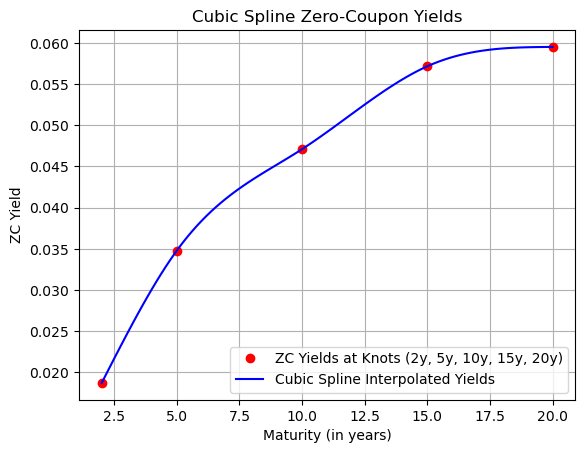

In [4]:
# We plot the CS interpolation
plt.plot(years, yields, 'o', label='ZC Yields at Knots (2y, 5y, 10y, 15y, 20y)', color='red')
plt.plot(years_range, spline_yields, label='Cubic Spline Interpolated Yields', color='blue')
plt.title('Cubic Spline Zero-Coupon Yields')
plt.xlabel('Maturity (in years)')
plt.ylabel('ZC Yield')
plt.legend()
plt.grid(True)
plt.show()

<b><u>Q.2.2</b></u>

<u>When to use cubic splines ?</u> 

- Compared to the ZC yields obtained by boostrapping, the estimates from cubic spline avoids the jumps in the curve.
- We have more stable valuations to use thereafter, and a continuous yield curve here.
- The cs() function here is constructed to ensure smoothness at each knot. We here have a sparse data points with yields only at certain maturities, so its pretty useful to have a continuous curve here (it will reduce the estimation error in the curve).
- But the problem here is that we used this non continuous curve and the volatility in the yield data to propose some trades in Q.1.2: therefore the cubic spline can smooth out these details and affect our former analysis.

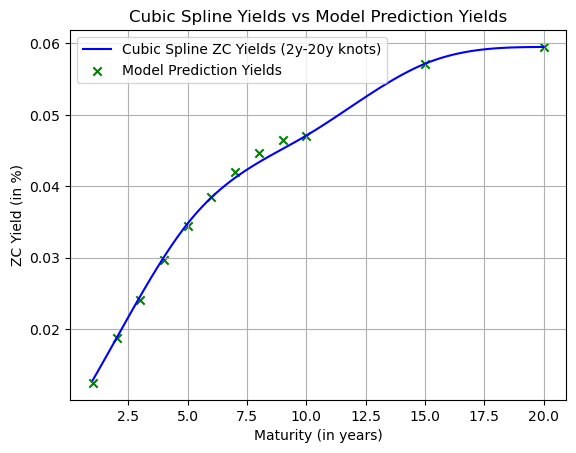

In [5]:
years = np.array([2, 5, 10, 15, 20])
yields = np.array([0.018727, 0.034799, 0.047107, 0.057167, 0.059513])
cs = CubicSpline(years, yields, bc_type='natural')

model_pred_matu = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20])
model_pred_yields = np.array([0.012443, 0.018727, 0.024110, 0.029665, 0.034454, 
                              0.038557, 0.041996, 0.044677, 0.046528, 0.047107, 
                              0.057160, 0.059517])

years_range = np.linspace(1, 20, 100)
spline_yields = cs(years_range)
plt.plot(years_range, spline_yields, label='Cubic Spline ZC Yields (2y-20y knots)', color='blue')
plt.scatter(model_pred_matu, model_pred_yields, color='green', label='Model Prediction Yields', marker='x')
plt.title('Cubic Spline Yields vs Model Prediction Yields')
plt.xlabel('Maturity (in years)')
plt.ylabel('ZC Yield (in %)')
plt.legend()
plt.grid(True)
plt.show()

We see that for maturity = 7, 8 and 9 years we have a model predicted yield that is higher than our CS curve.
That was not the case when we bootstrapped the ZC in our excel !

<b><u>Q.2.3</b></u>

In [6]:
years2 = np.array([5,20])
yields2 = np.array([0.034799,0.059513])
cs = CubicSpline(years2, yields2, bc_type='natural')

In [7]:
years_range = np.linspace(5.0, 20, 100)
spline_yields2 = cs(years_range)

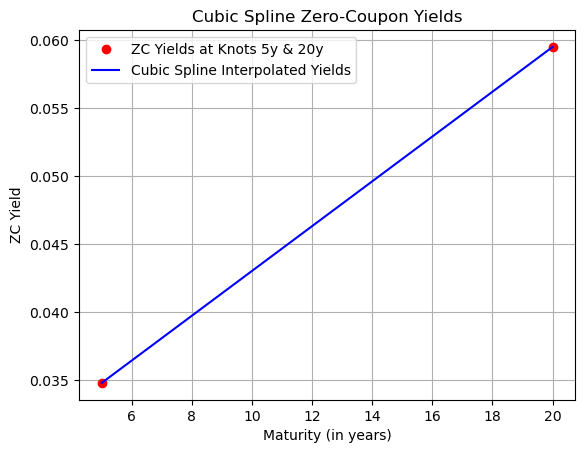

In [8]:
plt.plot(years2, yields2, 'o', label='ZC Yields at Knots 5y & 20y', color='red')
plt.plot(years_range, spline_yields2, label='Cubic Spline Interpolated Yields', color='blue')
plt.title('Cubic Spline Zero-Coupon Yields')
plt.xlabel('Maturity (in years)')
plt.ylabel('ZC Yield')
plt.legend()
plt.grid(True)
plt.show()

<u>What is the impact of having fewer knots ?</u>

- We only have two points to fit so it is a straight line here.
- It clearly loses precision for the intermediate maturities here, compared to our curve for the 2y-...-20y knots. The yield dynamic is actually clearly not captured here.
- There is less granularity and it kind of underfit for the intermediate maturities. This might affect the strategies we will be implementing thereafter.
- We see that there is a tradeoff actually between flexibility and accuracy. It might be more practical to use the fewer knots curve, but we lose in accuracy.

## QUESTION 3: Nelson-Siegel Model

<b><u>Q.3.1</b></u>

In [9]:
from scipy.optimize import minimize

def nelson_siegel_svensson(maturities, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-maturities / tau1)) / (maturities / tau1)
    term3 = beta2 * ((1 - np.exp(-maturities / tau1)) / (maturities / tau1) - np.exp(-maturities / tau1))
    term4 = beta3 * ((1 - np.exp(-maturities / tau2)) / (maturities / tau2) - np.exp(-maturities / tau2))
    return term1 + term2 + term3 + term4

def objective(params, maturities, yields_observed):
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    yields_model = nelson_siegel_svensson(maturities, beta0, beta1, beta2, beta3, tau1, tau2)
    return np.sum((yields_observed - yields_model) ** 2)

initial_params = [0.03, -0.02, 0.05, 0.01, 3.0, 5.0]
cs_maturity = np.array([2, 5, 10, 15, 20])
cs_yield = np.array([0.018727, 0.034799, 0.047107, 0.057167, 0.059513])

result = minimize(objective, initial_params, args=(cs_maturity, cs_yield), method='L-BFGS-B')
beta0_opt, beta1_opt, beta2_opt, beta3_opt, tau1_opt, tau2_opt = result.x

all_maturities = np.arange(0.5, 26.5, 0.5)
all_yields = np.array([
    0.008819, 0.011930, 0.015753, 0.018727, 0.021742, 0.024711, 
    0.027905, 0.030084, 0.032544, 0.034799, 0.036549, 0.038817, 
    0.040751, 0.042203, 0.043517, 0.044865, 0.045878, 0.046640, 
    0.046965, 0.047107, 0.047357, 0.049285, 0.053289, 0.053826, 
    0.054624, 0.055197, 0.055743, 0.056635, 0.056736, 0.057167, 
    0.057897, 0.058298, 0.058503, 0.059023, 0.059162, 0.059299, 
    0.059492, 0.059563, 0.059660, 0.059513, 0.059397, 0.059789, 
    0.060015, 0.059962, 0.059456, 0.059823, 0.059647, 0.059603, 
    0.059557, 0.059128, 0.058783, 0.059049
])
yield_curve_fitted = nelson_siegel_svensson(all_maturities, beta0_opt, beta1_opt, beta2_opt, beta3_opt, tau1_opt, tau2_opt)
spline_yields = CubicSpline(cs_maturity, cs_yield,bc_type='natural')(all_maturities)

In [10]:
mat = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25])
yield_f = np.array([0.012443, 0.018727, 0.024110, 0.029665, 0.034454, 0.038557, 0.041996, 0.044677, 
                    0.046528, 0.047107, 0.057160, 0.059517, 0.059315])
yields = np.array([0.011930, 0.018727, 0.024711, 0.030084, 0.034799, 0.038817, 0.042203, 0.044865, 
                   0.046640, 0.047107, 0.057167, 0.059513, 0.059128])

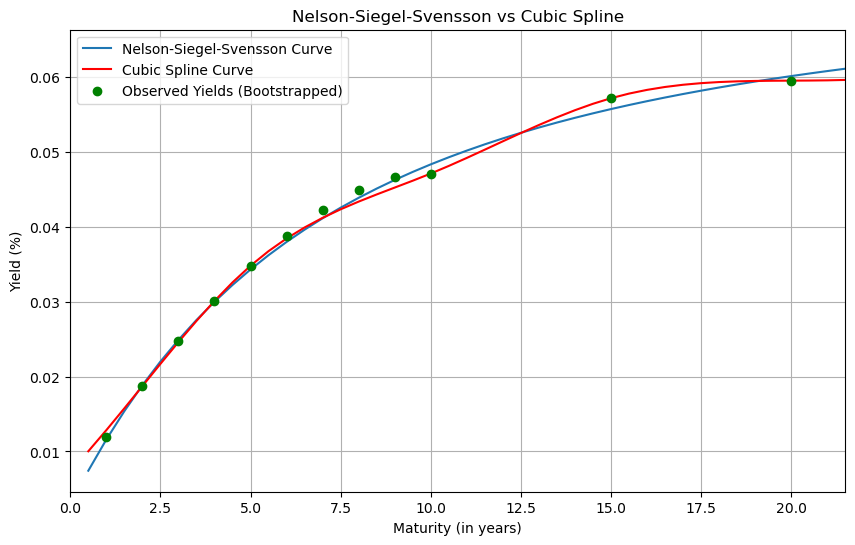

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(all_maturities, yield_curve_fitted, label='Nelson-Siegel-Svensson Curve')
plt.plot(all_maturities, spline_yields, 'r-', label='Cubic Spline Curve')
plt.scatter(mat, yields, color='green', label='Observed Yields (Bootstrapped)', zorder=5)
plt.xlabel('Maturity (in years)')
plt.ylabel('Yield (%)')
plt.title('Nelson-Siegel-Svensson vs Cubic Spline')
plt.xlim(0, 21.5)
plt.legend()
plt.grid(True)
plt.show()

<b><u>Q.3.3</b></u>

In [12]:
# Here we first plot the factor loadings of our Nelson-Siegel Model
factor_beta0_opt = np.ones_like(all_maturities) 
factor_loading_slope = (1 - np.exp(- all_maturities / tau1_opt)) / ( all_maturities / tau1_opt) 
factor_loading_curvature1 = (1 - np.exp(- all_maturities / tau1_opt)) / ( all_maturities / tau1_opt) - np.exp(- all_maturities / tau1_opt) 
factor_loading_curvature2 = (1 - np.exp(- all_maturities / tau2_opt)) / ( all_maturities / tau2_opt) - np.exp(- all_maturities / tau2_opt)
spot_contribution_level = beta0_opt * np.ones_like(all_maturities) 
spot_contribution_slope = beta1_opt * factor_loading_slope 
spot_contribution_curvature1 = beta2_opt * factor_loading_curvature1 
spot_contribution_curvature2 = beta3_opt * factor_loading_curvature2

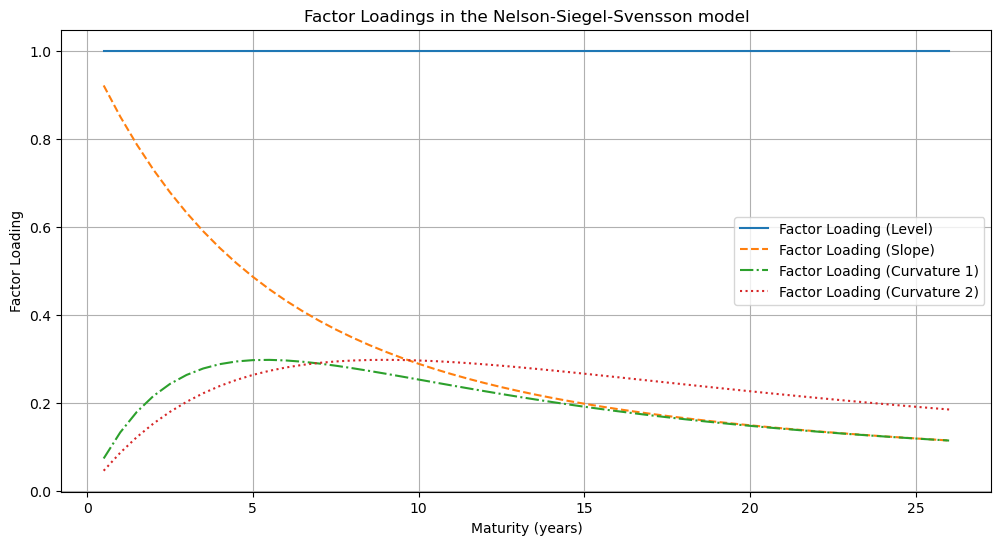

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(all_maturities, factor_beta0_opt, label="Factor Loading (Level)", linestyle='-') 
plt.plot(all_maturities, factor_loading_slope, label="Factor Loading (Slope)", linestyle='--') 
plt.plot(all_maturities, factor_loading_curvature1, label="Factor Loading (Curvature 1)", linestyle='-.') 
plt.plot(all_maturities, factor_loading_curvature2, label="Factor Loading (Curvature 2)", linestyle=':') 
plt.xlabel("Maturity (years)") 
plt.ylabel("Factor Loading") 
plt.title("Factor Loadings in the Nelson-Siegel-Svensson model") 
plt.legend() 
plt.grid(True) 
plt.show() 

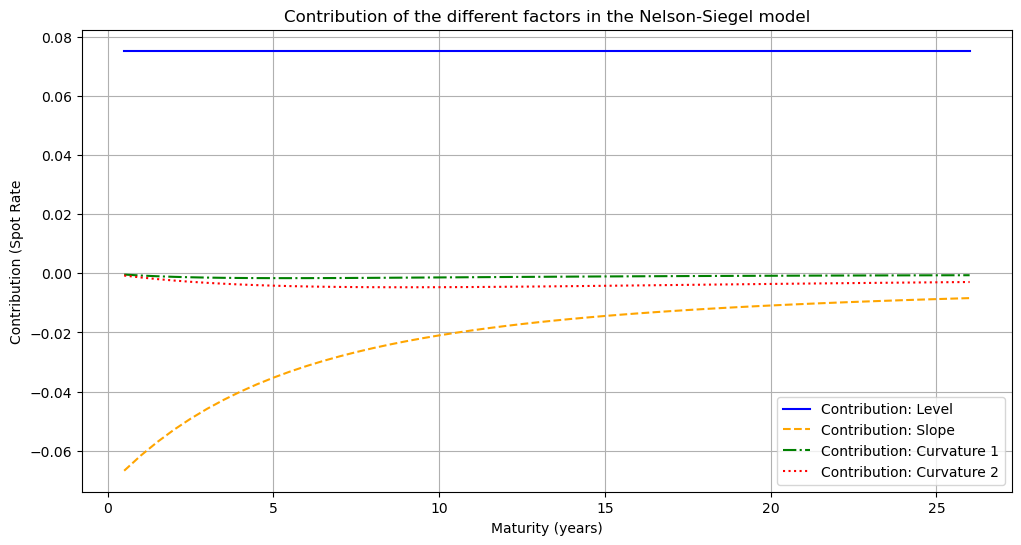

In [14]:
plt.figure(figsize=(12, 6)) 
plt.plot(all_maturities, spot_contribution_level, label="Contribution: Level", color='blue') 
plt.plot(all_maturities, spot_contribution_slope, label="Contribution: Slope", linestyle='--', color='orange') 
plt.plot(all_maturities, spot_contribution_curvature1, label="Contribution: Curvature 1", linestyle='-.', color='green') 
plt.plot(all_maturities, spot_contribution_curvature2, label="Contribution: Curvature 2", linestyle=':', color='red') 
plt.xlabel("Maturity (years)") 
plt.ylabel("Contribution (Spot Rate") 
plt.title("Contribution of the different factors in the Nelson-Siegel model") 
plt.legend() 
plt.grid(True) 
plt.show() 

## QUESTION 4: Hedging

<b><u>Q.4.1</b></u>

In [15]:
# We shock here the 10yr rate by 50 bps + plot the difference for the Cubic Spline model
# We have seen previously that the more knot points there are, the better the Cubic Spline fit so we will now use those 13 knot points for this question:
maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25])
yields = np.array([0.011930, 0.018727, 0.024711, 0.030084, 0.034799, 0.038817, 
                   0.042203, 0.044865, 0.046640, 0.047107, 0.057167, 0.059513, 0.059128])
yields_shocked = np.array([0.011930, 0.018727, 0.024711, 0.030084, 0.034799, 0.038817, 
                   0.042203, 0.044865, 0.046640, 0.047107 + 0.005, 0.057167, 0.059513, 0.059128])

cs = CubicSpline(maturities, yields,bc_type='natural')
all_maturities = np.arange(0.5, 26.5, 0.5)
original_yield_curve = cs(all_maturities)

cs_shocked = CubicSpline(maturities, yields_shocked,bc_type='natural')
cs = CubicSpline(maturities, yields,bc_type='natural')
shocked_yield_curve = cs_shocked(all_maturities)

In [64]:
def get_krd_price(mat,shock):
    cf = np.zeros((52,52))
    mat=int((mat-0.50)*2)
    shock=shock*100
    for i in range(52):
        for j in range(i+1):
            if j == i:
                cf[i][j]= ex_1.iloc[i,0]/2 + 100
            else:
                cf[i][j]= ex_1.iloc[i,0]/2
    for i in range(mat+1):
        if i == mat :
            cf[mat][i]=(ex_1.iloc[mat,0]+shock)/2 + 100 
        else :
            cf[mat][i]=(ex_1.iloc[mat,0]+shock)/2
    cf_inv = np.linalg.inv(cf)
    discount_krd_prices = np.dot(cf_inv,mp)
    return discount_krd_prices

def get_krd2(mat,shock):
    krd_p=get_krd_price(mat,shock).reshape(52,)
    w=1000000/sum(discount_prices.reshape(52,))
    krd_diff = krd_p - discount_prices.reshape(52,)
    krd = sum(krd_diff)*w
    return krd

yield_f[2]

0.02411

In [66]:
cs_kdr_yield=np.array([yield_f[1],yield_f[4],((1/get_krd_price(10,0.005)[19])**(1/20)-1)*2,yield_f[10],yield_f[11]],dtype=object)
cs_kdr = CubicSpline(cs_maturity,cs_kdr_yield, bc_type='natural')
interpolated__kdryields = cs_kdr(all_maturities)

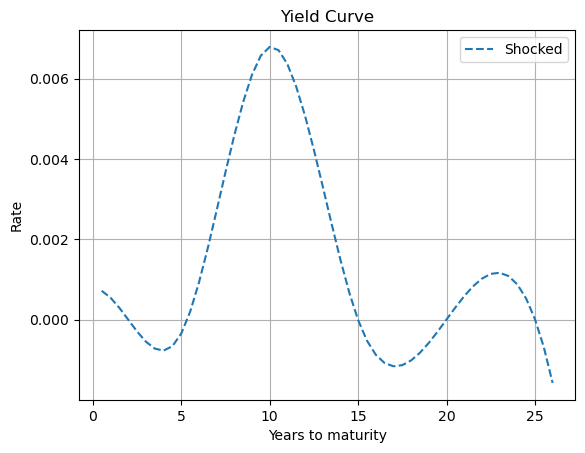

In [68]:
#plt.plot(all_maturities,interpolated_yields,'-',label='Yield curve')
plt.plot(all_maturities,interpolated__kdryields-spline_yields,'--',label='Shocked')
plt.xlabel('Years to maturity')
plt.ylabel('Rate')
plt.legend()
plt.title('Yield Curve')
#plt.xlim(0,20)
plt.grid()

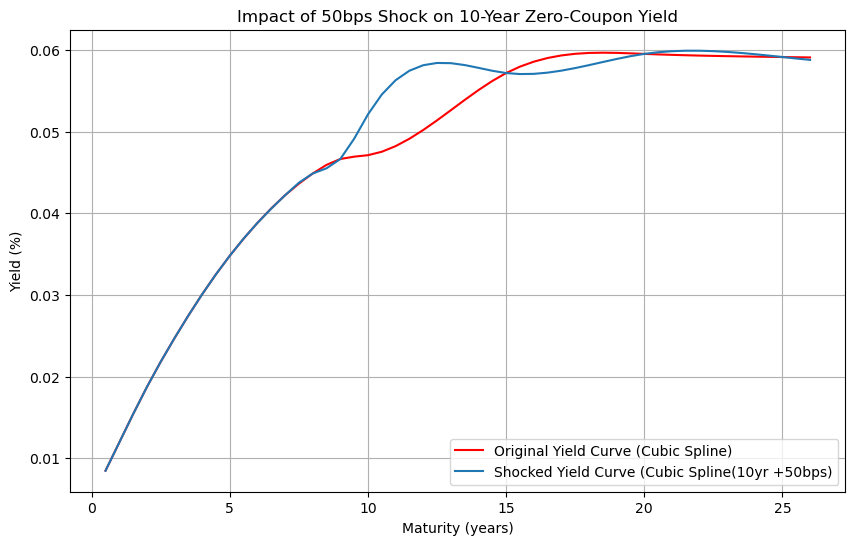

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(all_maturities, original_yield_curve,'r', label='Original Yield Curve (Cubic Spline)')
plt.plot(all_maturities, shocked_yield_curve,label='Shocked Yield Curve (Cubic Spline(10yr +50bps)')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield (%)')
plt.title('Impact of 50bps Shock on 10-Year Zero-Coupon Yield')
plt.legend()
plt.grid(True)
plt.show()

<b><u>Q.4.2</b></u>

In [17]:
# Step 1: Create a cubic spline based on maturities and yields
specific_spline = CubicSpline(maturities, yields)
yields_shocked = np.array([0.011930, 0.018727, 0.024711, 0.030084, 0.034799, 0.038817, 
                   0.042203, 0.044865, 0.046640, 0.047107 + 0.005, 0.057167, 0.059513, 0.059128])
shocked_spline = CubicSpline(maturities, shocked_yields)

# Step 3: Define the function to calculate bond price based on the specific yield curve spline
def calculate_bond_price(maturity, yield_curve_spline, individual_bond_value):
    yield_rate = yield_curve_spline(maturity)  # Interpolate yield
    discount_factor = np.exp(-yield_rate * maturity)  # Discount factor for zero-coupon
    bond_price = discount_factor * individual_bond_value
    return bond_price

# Portfolio setup
portfolio_value = 1_000_000
num_bonds = len(all_maturities)
individual_bond_value = portfolio_value / num_bonds

# Step 4: Calculate bond prices using the specific spline for maturities and yields for all_maturities
original_prices = [calculate_bond_price(maturity, specific_spline, individual_bond_value) for maturity in all_maturities]
shocked_prices = [calculate_bond_price(maturity, shocked_spline, individual_bond_value) for maturity in all_maturities]

# Step 5: Calculate the total price change for the portfolio
price_changes = np.array(original_prices) - np.array(shocked_prices)  # Price changes for all bonds
total_price_change = np.sum(price_changes)  # Total price change for the entire portfolio

# Calculate the KRD for the portfolio in dollar terms
krd_total = total_price_change
krd_total

#print(f"Total Price Change: ${total_price_change:,.2f}")
#print(f"Portfolio KRD (dollars) for 10-year rate shock: ${krd_total:,.2f}")



NameError: name 'shocked_yields' is not defined

In [69]:
get_krd2(10,0.005)

-404.4830116407338

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(all_maturities,,'--',label='Shocked')
plt.xlabel('Years to maturity')
plt.ylabel('Rate')
plt.legend()
plt.title('Yield Curve')
#plt.xlim(0,20)
plt.grid()

<b><u>Q.4.3</b></u>

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline

# Define the maturities and yields
all_maturities = np.array([
    0.5, 1, 2, 3, 5, 7, 10, 12, 15, 20, 25, 30  # Example maturities in years
])

all_yields = np.array([
    0.008819, 0.011930, 0.015753, 0.018727, 0.021742, 0.024711, 
    0.027905, 0.030084, 0.032544, 0.034799, 0.036549, 0.038817, 
    0.040751, 0.042203, 0.043517, 0.044865, 0.045878, 0.046640, 
    0.046965, 0.047107, 0.047357, 0.049285, 0.053289, 0.053826, 
    0.054624, 0.055197, 0.055743, 0.056635, 0.056736, 0.057167, 
    0.057897, 0.058298, 0.058503, 0.059023, 0.059162, 0.059299, 
    0.059492, 0.059563, 0.059660, 0.059513, 0.059397, 0.059789, 
    0.060015, 0.059962, 0.059456, 0.059823, 0.059647, 0.059603, 
    0.059557, 0.059128, 0.058783, 0.059049
])

# Shock value
shock = 0.005

# Define shocked yields based on all_yields
shocked_yields = all_yields
shocked_yields[19] = all_yields[19]+shock
print(all_yields[19])
def calculate_krd(original_yields, shocked_yields, maturities):
    portfolio_value = 1_000_000  # Total portfolio value
    krd = []
    
    for i in range(len(maturities)):
        # Calculate the original and shocked prices
        original_price = portfolio_value * np.exp(-original_yields[i] * maturities[i])
        shocked_price = portfolio_value * np.exp(-shocked_yields[i] * maturities[i])
        print(original_price)
        # Calculate the price change
        price_change = shocked_price - original_price
        
        # Calculate KRD value based on price change
        krd_value = price_change / shock
        krd.append(krd_value)
        
    return np.array(krd)

# Calculate KRDs using the defined yields
krds = calculate_krd(all_yields, shocked_yields, all_maturities)
print("Key Rate Durations (KRDs):", krds)


In [ ]:
# Plotting KRDs
plt.figure(figsize=(10, 6))
plt.plot(all_maturities, krds, marker='o', color='blue', label='KRDs after 50bps shock')
plt.title('Key Rate Durations (KRDs) for Portfolio Across Maturities')
plt.xlabel('Maturity (Years)')
plt.ylabel('Key Rate Duration (KRD)')
plt.grid(True)
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.show()

In [71]:
def get_krds(all,shock):
    KRD = np.ones(52,)
    for k in range(len(all)):
        mm=(k/2)+0.5
        KRD[k]=get_krd2(mm,shock)
        #print('KRD pour une maturité '+ str(mm) + ' : '+str(get_krd2(mm,shock)))
    return KRD

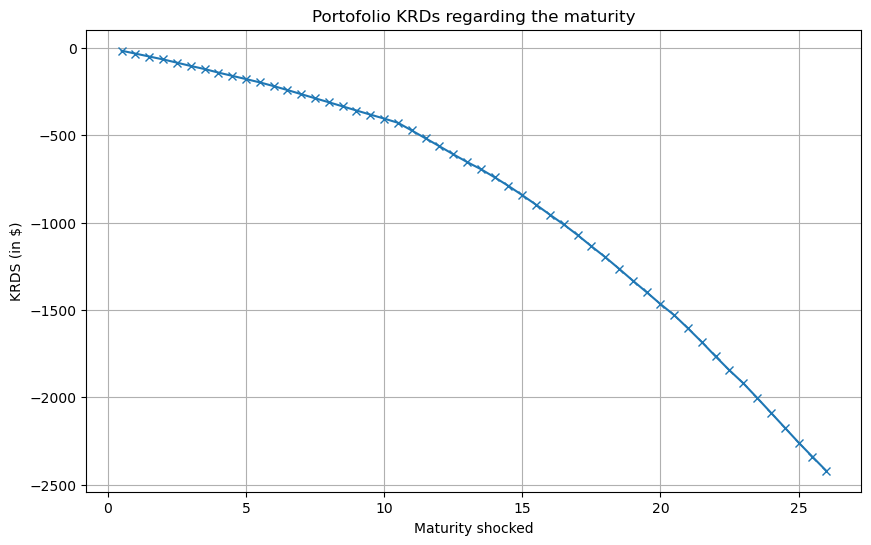

In [77]:
plt.figure(figsize=(10,6))
plt.plot(all_maturities,get_krds(all_maturities,0.005),'x-',label='Portofolio KRDs regarding the maturity')
plt.xlabel('Maturity shocked')
plt.ylabel('KRDS (in $)')
#plt.legend()
plt.title('Portofolio KRDs regarding the maturity')
#plt.xlim(0,20)
plt.grid()

## QUESTION 5: Portfolio Strategy

<b><u>Q.5.1</b></u>

In [42]:
average_maturity = np.mean(all_maturities)
stochastic_component = np.random.normal(0, 0.0025,52)
deterministic_component = ((all_maturities - average_maturity)/average_maturity * 0.005)
yields_1D = all_yields.reshape(-1,)
y_steepen = yields_1D + deterministic_component + stochastic_component

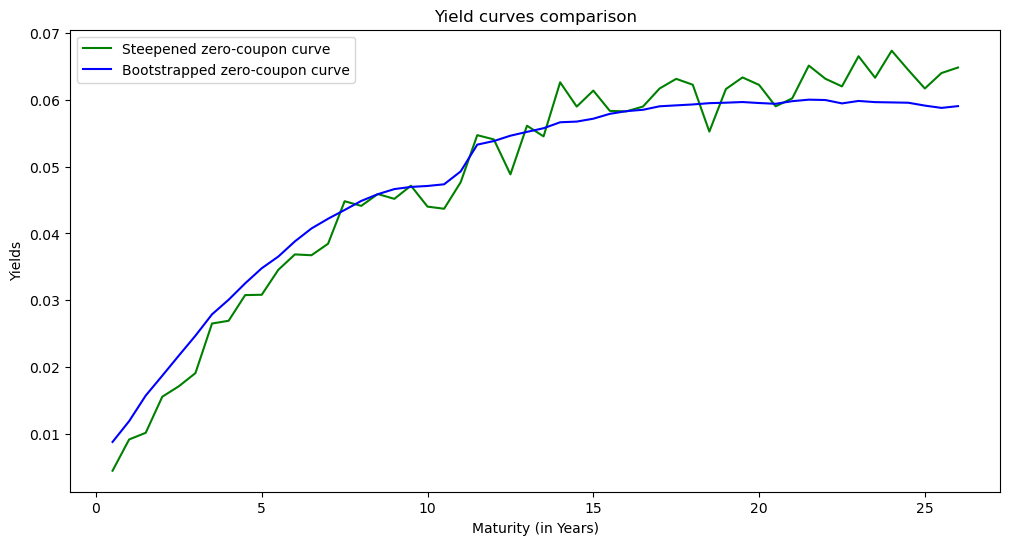

In [43]:
plt.figure(figsize=(12,6))
plt.plot(all_maturities, y_steepen, label='Steepened zero-coupon curve', color='green')
plt.plot(all_maturities, all_yields, label='Bootstrapped zero-coupon curve', color='blue')
plt.xlabel('Maturity (in Years)') 
plt.ylabel('Yields')
plt.title('Yield curves comparison')
plt.legend()
plt.grid
plt.show()

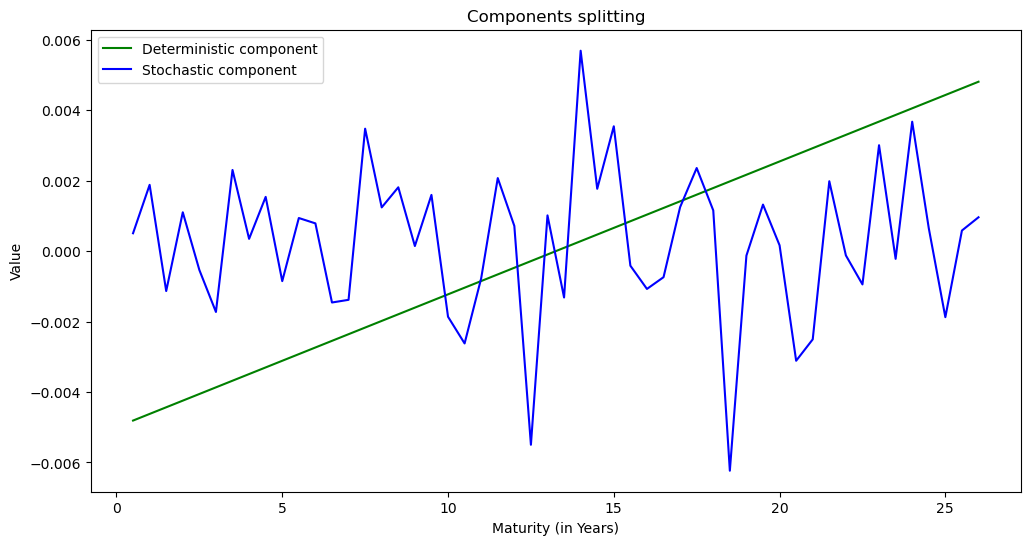

In [44]:
plt.figure(figsize=(12,6))
plt.plot(all_maturities, deterministic_component, label='Deterministic component', color='green')
plt.plot(all_maturities, stochastic_component, label='Stochastic component', color='blue')
plt.xlabel('Maturity (in Years)') 
plt.ylabel('Value')
plt.title('Components splitting')
plt.legend()
plt.grid
plt.show()

<b><u>Q.5.2</b></u>

In [45]:
nss_steep_yield=np.array([])
for i in cs_maturity:
    nss_steep_yield=np.append(nss_steep_yield,y_steepen[i*2-1])

In [46]:
initial_params_steep = [0.03, 0.015, 0.005, 0.003, 3, 6]
result_steep = minimize(objective, initial_params_steep, args=(cs_maturity, nss_steep_yield), method='L-BFGS-B')
beta0_steep, beta1_steep, beta2_steep, beta3_steep, tau1_steep, tau2_steep = result_steep.x
yield_curve_steep = nelson_siegel_svensson(all_maturities, beta0_steep, beta1_steep, beta2_steep, beta3_steep, tau1_steep, tau2_steep)

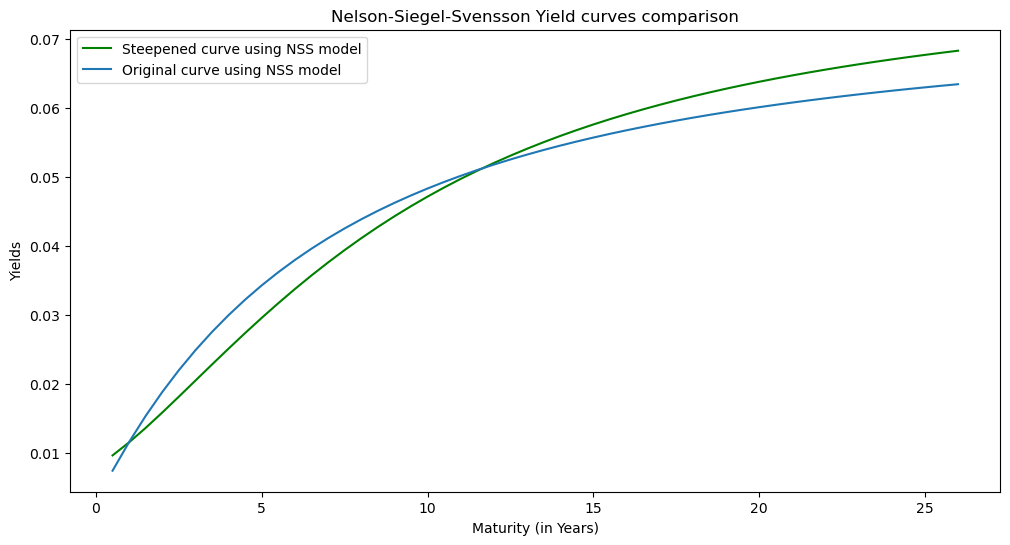

In [47]:
plt.figure(figsize=(12,6))
plt.plot(all_maturities, yield_curve_steep, label='Steepened curve using NSS model', color='green')
plt.plot(all_maturities, yield_curve_fitted, label='Original curve using NSS model')
#plt.plot(all_maturities, stochastic_component, label='Stochastic component', color='blue')
plt.xlabel('Maturity (in Years)') 
plt.ylabel('Yields')
plt.title('Nelson-Siegel-Svensson Yield curves comparison')
plt.legend()
plt.grid
plt.show()

In [48]:
discount_matrix = 1/(1+yield_curve_steep)
for i in range(52):
    discount_matrix[i]=1/((1+yield_curve_steep[i])**((i+1)/2))

In [49]:
new_market_prices = cashflows @ discount_matrix

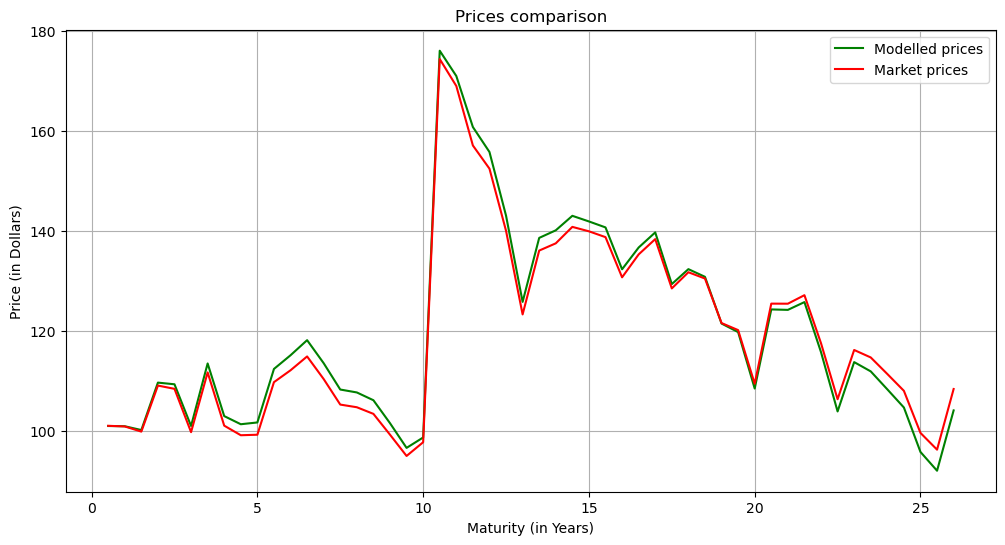

In [50]:
plt.figure(figsize=(12,6))
plt.plot(all_maturities, new_market_prices, label='Modelled prices', color='green')
plt.plot(all_maturities, market_price, label='Market prices',color='red')
#plt.plot(all_maturities, stochastic_component, label='Stochastic component', color='blue')
plt.xlabel('Maturity (in Years)') 
plt.ylabel('Price (in Dollars)')
plt.title('Prices comparison')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
cheap_expensive = market_price - new_market_prices

<b><u>Q.5.3</b></u>

In [52]:
desired_mp = np.ones(10,)
for i,j in zip([6, 10, 15, 23, 28, 37, 42, 45, 47, 52],range(10)):
    desired_mp[j] = market_price[i-1]       #market price est la matrice de tous les prix obtenus question 1.1

In [53]:
desired_model_price = np.ones(10,)
for i,j in zip([6, 10, 15, 23, 28, 37, 42, 45, 47, 52],range(10)):
    desired_model_price[j] = new_market_prices[i-1]

In [54]:
def obj_0(weights):
    return abs(weights @ desired_mp)

In [55]:
weeight = np.ones(10,)

In [56]:
weeight[5:10]=-weeight[5:10]

In [57]:
opti_ptf = minimize(obj_0, weeight, method='L-BFGS-B')

In [61]:
final_weights = opti_ptf.x
final_weights

array([ 0.99060214,  0.99065054,  0.99008333,  0.98520835,  0.98704969,
       -1.01228817, -1.01181472, -1.01001737, -1.0108034 , -1.01020983])

In [59]:
long_short_return = final_weights * (desired_mp - desired_model_price)

In [60]:
sum(abs(long_short_return))

24.01912200304666